In [7]:
### Setting up the environment.

import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

allData = pd.read_csv('db_mlb_project_weekp3.csv')
allData['GameDate'] = pd.to_datetime(allData['GameDate'], format='%Y-%m-%d')
print allData.shape

### Eliminating nans
#      Two sources that we have identified:
#          1) First seven rows, due to bizarre shift behavior. (totally okay with this)
#          2) Times when some quantity was zero and then divided by. (mostly okay with because rare)
allData = allData.replace([np.inf, -np.inf], np.nan)
allData = allData.dropna()
print allData.shape
print list(allData)

(38835, 42)
(38835, 42)
['Unnamed: 0', 'Name', 'IP', 'H', 'ER', 'BB', 'SO', 'ERA', 'BF', 'Pit', 'Str', 'GB', 'GameDate', 'interceptRow', 'Age', 'mIP', 'cERA', 'cfGB', 'cfSO', 'cfStr', 'rIP', 'rBF', 'rPit', 'rERA', 'rfGB', 'rfSO', 'rfStr', 'dIP', 'drIP', 'dERA', 'drERA', 'fGB', 'dfGB', 'drfGB', 'fSO', 'dfSO', 'drfSO', 'fStr', 'dfStr', 'drfStr', 'targets', 'boost']


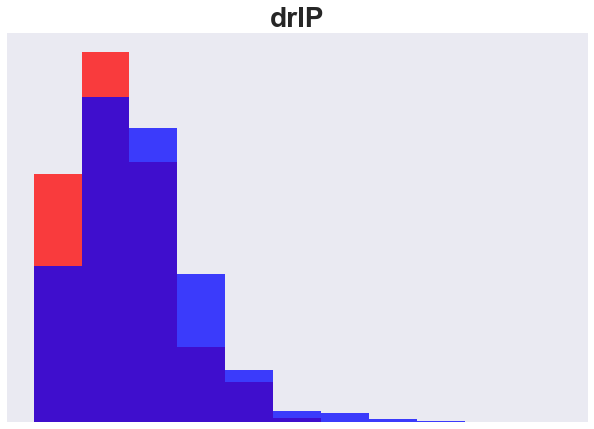

(253, 42)


In [9]:
bins = np.linspace(allData.SO.min(),allData.SO.max(),12)
posData = allData[allData['targets']==1]
negData = allData[allData['targets']==-1]
ax1 = posData.SO.plot.hist(bins, alpha=0.75, label='Injured', color='red', normed=True)
ax2 = negData.SO.plot.hist(bins, alpha=0.75, label='Healthy', color='blue', normed=True)
plt.title('drIP',fontsize=28,fontweight='bold')
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()
print posData.shape

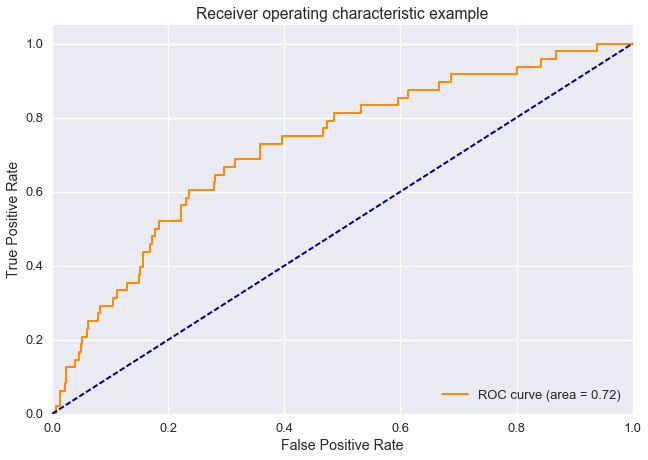

In [10]:
### Eliminate last game of pitcher's career.
### Eliminate pitchers with age 0.

import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split

featureList = ['Age', 'boost', \
              'ERA','rERA','cERA','dERA','drERA', \
              'IP','rIP','mIP','dIP','drIP', \
              'fGB','rfGB','cfGB','dfGB','drfGB', \
              'fSO','rfSO','cfSO','dfSO','drfSO', \
              'fStr','rfStr','cfStr','dfStr','drfStr']


for i in range(1):
    
#    posTrainData = allData[(allData['GameDate']<datetime.date(2002+i,1,1)) & \
#                          (allData['targets']==1)]
#    negTrainData = allData[(allData['GameDate']<datetime.date(2002+i,1,1)) & \
#                          (allData['targets']==-1)]
    
#    trainData = pd.concat([negTrainData,posTrainData])
#    posTestData = allData[(allData['GameDate']>datetime.date(2002+i,1,1)) & \
#                         (allData['GameDate']<datetime.date(2003+i,1,1)) & \
#                         (allData['targets']==1)]
#    negTestData = allData[(allData['GameDate']>datetime.date(2002+i,1,1)) & \
#                         (allData['GameDate']<datetime.date(2003+i,1,1)) & \
#                         (allData['targets']==-1)]
    
#    testData = pd.concat([negTestData,posTestData])

#    Xtrain = trainData[featureList].values
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(allData.loc[allData['targets']!=0,featureList],\
                                                   allData.loc[allData['targets']!=0,'targets'],test_size=0.2)
#    Xtest = testData[featureList].values
#    Ytrain = trainData[['targets']].values
#    Ytrain = Ytrain.flatten()
#    Ytest = testData[['targets']].values
#    Ytest = Ytest.flatten()

    model = RandomForestClassifier(n_estimators=1000,max_depth=4,max_features=3,class_weight="balanced",oob_score=True)
    model.fit(Xtrain,Ytrain)
    
    #am[i,1] = accuracy_score(Ytest,model.predict(Xtest))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(Ytest, model.predict_proba(Xtest)[:,1])
    roc_auc = auc(fpr, tpr)
    #am[i,0] = roc_auc
    #print am[i,:]
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', \
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [14]:
allData['model'] = model.predict_proba(allData[featureList].values)[:,1]
print Xtest.shape

(2529, 27)


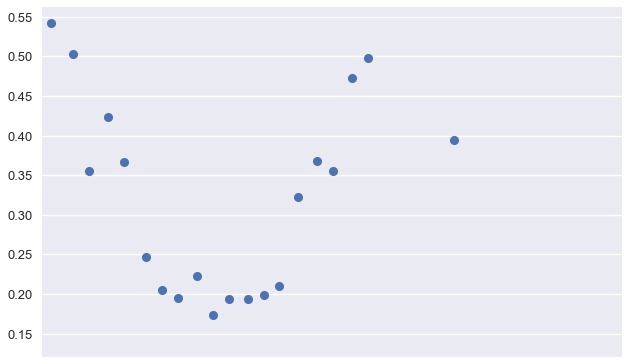

In [16]:
import matplotlib.pyplot as plt
from matplotlib.finance import quotes_historical_yahoo_ochl
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
import datetime
years = YearLocator()   # every year
months = MonthLocator()  # every month
yearsFmt = DateFormatter('%Y')
tseries = allData[allData['Name'].values=='contrjo01']
xd = tseries['GameDate'].values
yd = tseries['model'].values
fig, ax = plt.subplots()
ax.plot_date(xd,yd)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.autoscale_view()
ax.set_xlim(xmin=datetime.date(2008, 4, 1),xmax=datetime.date(2008,10,1))
fig.autofmt_xdate()
plt.show()
#plt.show()

In [10]:
### Export production values.

from sklearn.externals import joblib
joblib.dump(model, 'model.pkl') 
#pickle.dump(model,open('model.p','wb'))
joblib.dump(allData['model'].values,'prcTable.pkl')
#print type(fy)
print featureList
featureList.append('targets')
final = allData[featureList]
final.to_csv('db_mlb_production.csv')

['Age', 'boost', 'ERA', 'rERA', 'cERA', 'dERA', 'drERA', 'IP', 'rIP', 'mIP', 'dIP', 'drIP', 'fGB', 'rfGB', 'cfGB', 'dfGB', 'drfGB', 'fSO', 'rfSO', 'cfSO', 'dfSO', 'drfSO', 'fStr', 'rfStr', 'cfStr', 'dfStr', 'drfStr', 'targets']


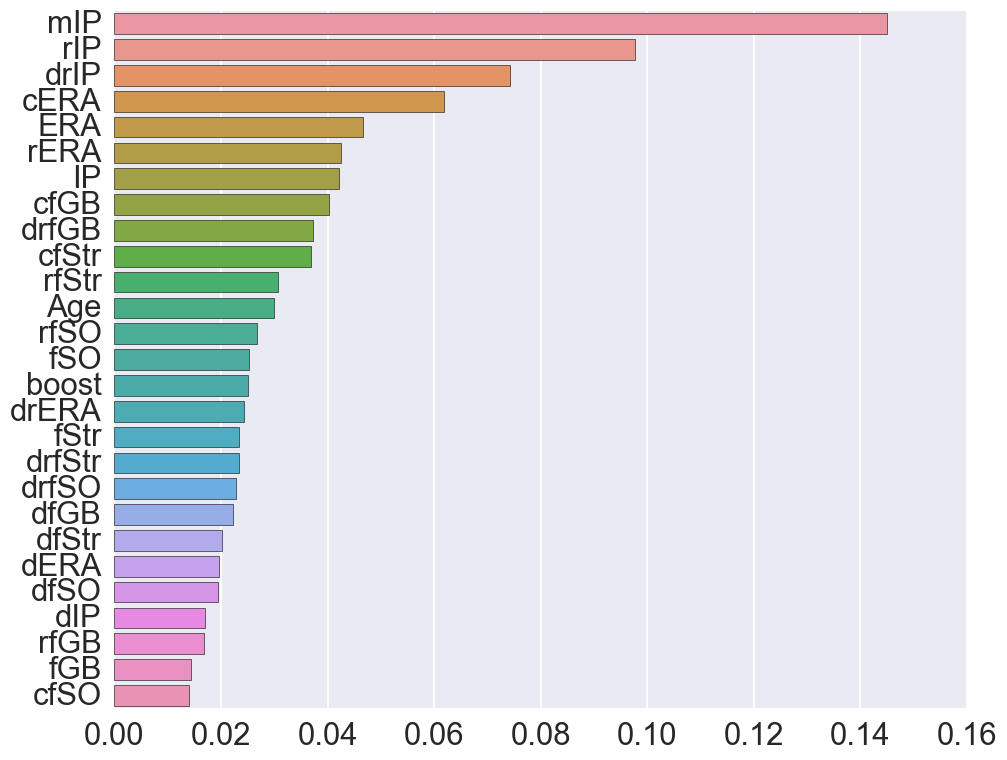

In [6]:
### Metrics
Xlabels = featureList
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
rfc = model
feature_importance = (np.vstack((np.arange(len(rfc.feature_importances_)), rfc.feature_importances_)).T)
ranking = feature_importance[feature_importance[:,1].argsort()[::-1]]
ranked_list = []
ranked_labels = []
for rank, importance in ranking[:,:]:
    ranked_list.append(importance)
    ranked_labels.append(Xlabels[int(rank)])
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.barplot(x=ranked_list, y=ranked_labels)
plt.show()

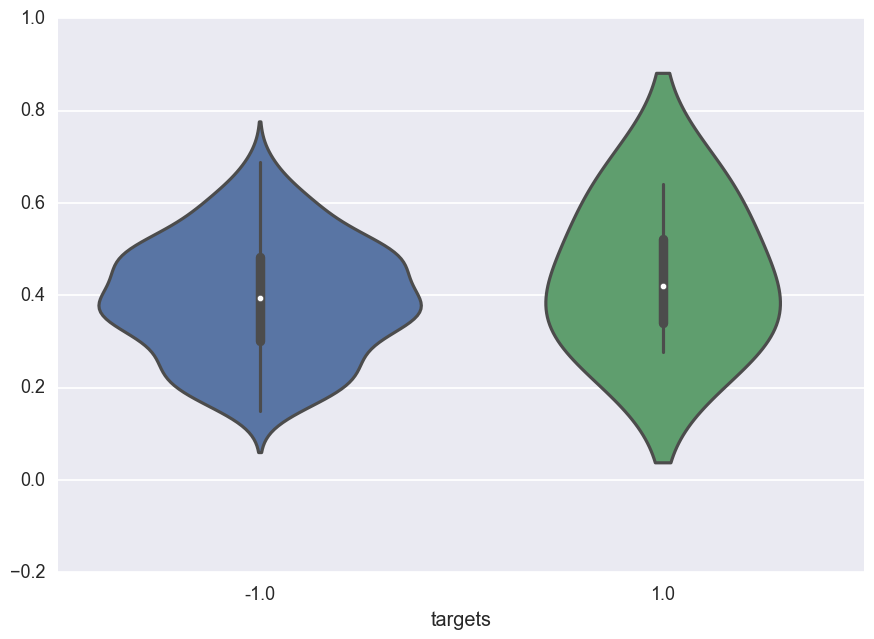

[ 0.30857527  0.30857527  0.30857527 ...,  0.45054203  0.30857527
  0.30857527]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


In [5]:
sns.violinplot(Ytest,model.predict_proba(Xtest)[:,1].flatten())
#print Ytest[Ytest==1], model.predict_proba(Xtest)[Ytest==1,1]
plt.show()
print model.predict_proba(Xtest)[Ytest==1,1]

In [1]:
### Downsample.
#posData = someData.loc[someData.index[someData['targets'].values==1],:]
#preNegData = someData.loc[someData.index[someData['targets'].values==0],:]
#negData = preNegData.sample(int(sum(posData['targets'])))
#frames = [negData, posData]
#dsData = pd.concat(frames)


### Set aside test data.
#ntData = dsData[dsData['GameDate']<datetime.date(2008,6,1)]
#tData = dsData[dsData['GameDate']>=datetime.date(2008,6,1)]
#print dsData.shape

#dsData['ncIP'] = (dsData['paIP']-dsData['paIP'].mean())/dsData['paIP'].std(ddof=0)
#dsData['nsIP'] = (dsData['sIP']-dsData['sIP'].mean())/dsData['sIP'].std(ddof=0)
#dsData['ncSO'] = (dsData['carKpBF']-dsData['carKpBF'].mean())/dsData['carKpBF'].std(ddof=0)
#dsData['nage'] = (dsData['ages']-dsData['ages'].mean())/dsData['ages'].std(ddof=0)
#dsData['nsSPerc'] = (dsData['sSPerc']-dsData['sSPerc'].mean())/dsData['sSPerc'].std(ddof=0)
#print dsData['paIP'].mean(),dsData['paIP'].std(ddof=0),dsData['sIP'].mean(),dsData['sIP'].std(ddof=0),\
#    dsData['carKpBF'].mean(),dsData['carKpBF'].std(ddof=0),dsData['ages'].mean(),dsData['ages'].std(),\
#    dsData['sSPerc'].mean(),dsData['sSPerc'].std(ddof=0)
#,'nsIP','ncSO','nage','nsSPerc'] = dsData
#df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
#dsData.to_csv('knndump.csv')
print Xtest.shape

NameError: name 'Xtest' is not defined

In [5]:
print testX.shape

NameError: name 'testX' is not defined

In [8]:
print np.average(allData['model'].values)

0.358173678152
